# Tutorial 1: Coordinates, Distributors, and Bases

**Overview:** This tutorial covers the basics of setting up and interacting with coordinate, distributor, and basis objects in Dedalus.
Dedalus uses spectral discretizations to represent fields and solve PDEs.
These discretizations are specified by selecting a spectral basis for the spatial coordinates of a problem.
The set of all coordinates needed in a problem are used to construct a distributor that controls how fields and problems defined on bases over these coordinates are distributed in parallel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

2021-11-20 21:25:18,684 numexpr.utils 0/1 INFO :: Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1.1: Coordinates

The spatial coordinates in a PDE are represented by coordinate objects in Dedalus.
Individual coordinates can be defined using the `Coordinate` class, which is primarily used for 1D problems.
In multiple dimensions, multiple coordinates can be constructed together as a `CoordinateSystem`.
The currently included coordinate systems are:
* `CartesianCoordinates` of any dimension.
* `PolarCoordinates` with azimuth and radius.
* `S2Coordinates` with azimuth and colatitude.
* `SphericalCoordaintes` with azimuth, colatitude, and radius.

When instantiating a `CoordinateSystem`, we provide the names we'd like to use for each coordinate, ordered as described in the list above.
Let's follow an example of setting up a problem in 3D Cartesia. coordinates.

In [3]:
coords = d3.CartesianCoordinates('x', 'y', 'z')

## 1.2: Distributors

`Distributor` objects direct the parallel decomposition of fields and problems, and is needed for all problems, even in serial.
To build a distributor, we pass the coordinate system of our PDE, specify the datatype of the fields we'll be using, and optionally specify a process mesh for parallelization.

In [4]:
dist = d3.Distributor(coords, dtype=np.float64) # No mesh for serial / automatic parallelization

### Parallelization & process meshes

When running in an MPI environment, Dedalus uses block-distributed domain decompositions to parallelize computation.
By default, problems are distributed across a 1-dimensional mesh of all the available MPI processes (i.e. a "slab" decomposition).
However, arbitrary process meshes (i.e. "pencil" decompositions) can be used by specifying a mesh shape with the `mesh` keyword when instantiating a domain.
The current MPI environment must have the same number of processes as the product of the mesh shape.

The mesh dimension must be less than or equal to the number of  separable coordinates in the linear part of our PDE.
Typically this means we can parallelize over an periodic and angular coordinates.
For fully separable problems, the mesh dimension must be less than the total dimension.

### Layouts

The distributor object builds the machinery necessary for the parallelized allocation and transformation of fields.  This includes an ordered set of `Layout` objects describing the necessary transform/distribution states of the data between coefficient space and grid space.
Subsequent layouts are connected by basis transforms, which must be performed locally, and global transposes (rearrangements of the data distribution across the process mesh) to achieve the required locality.

The general algorithm starts from coefficient space (layout 0), with the last axis local (non-distributed).
It proceeds towards grid space by transforming the last axis into grid space (layout 1).
Then it globally transposes the data (if necessary) such that the penultimate axis is local, transforms that axis into grid space, etc., until all axes have been transformed to grid space (the last layout).

Let's examine the layouts for the domain we just constructed.
For serial computations such as this, no global transposes are necessary (all axes are always local), and the paths between layouts consist of coefficient-to-grid transforms, backwards from the last axis:

In [5]:
for layout in dist.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [ True  True  True]
Layout 1:  Grid space: [False False  True]  Local: [ True  True  True]
Layout 2:  Grid space: [False  True  True]  Local: [ True  True  True]
Layout 3:  Grid space: [ True  True  True]  Local: [ True  True  True]


To see how things work for a distributed simulation, we'll change the specified process mesh shape and rebuild the layout objects, circumventing the internal checks on the number of available processes, etc.

**Note this is for demonstration only... messing with these attributes will generally break things.**

In [6]:
# Don't do this. For illustration only.
dist.mesh = np.array([4, 2])
dist.comm_coords = np.array([0, 0])
dist._build_layouts(dry_run=True)

In [7]:
for layout in dist.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [False False  True]
Layout 1:  Grid space: [False False  True]  Local: [False False  True]
Layout 2:  Grid space: [False False  True]  Local: [False  True False]
Layout 3:  Grid space: [False  True  True]  Local: [False  True False]
Layout 4:  Grid space: [False  True  True]  Local: [ True False False]
Layout 5:  Grid space: [ True  True  True]  Local: [ True False False]


We can see that there are now two additional layouts, corresponding to the transposed states of the mixed-transform layouts.
Two global transposes are necessary here in order for the $y$ and $x$ axes to be stored locally, which is required to perform the respective basis transforms.
Here's a sketch of the data distribution in the different layouts:

<img src="fig_layouts_fold.png" width="800px">

Interacting with the layout objects directly is typically not necessary, but being aware of this system for controlling the distribution and tranformation state of data is important for interacting with field objects, as we'll see in future notebooks.

## 1.3: Bases

### Creating a basis

Each type of basis in Dedalus is represented by a separate class.
These classes define the corresponding spectral operators and transforms between the "grid space" and "coefficient space" representations of functions in that basis.
The most commonly used bases are:

* `RealFourier` for real periodic functions on an interval using cosine & sine modes.
* `ComplexFourier` for complex periodic functions on an interval using complex exponentials.
* `Chebyshev` for functions on an interval.
* `Jacobi` for functions on an interval under a more general inner product (usually `Chebyshev` is best for performance).
* `DiskBasis` for functions on a full disk in polar coordinates.
* `AnnulusBasis` for functions on an annulus in polar coordinates.
* `SphereBasis` for functions on the 2-sphere in S2 or spherical coordinates.
* `BallBasis` for functions on a full ball in spherical coordinates.
* `ShellBasis` for functions on a spherical shell in spherical coordinates.

The one-dimensional / Cartesian bases are instantiated with:
* the corresponding coordinate object,
* the number of modes for the basis,
* the bounds of the basis interval.

The multidimensional / curvilinear bases are instantiated with:
* the corresponding coordinate system,
* the multidimensional mode shape for the basis, 
* the radial extent of the basis, 
* the problem dtype.

Optionally, for all bases you can specify a dealiasing scale factors for each basis axis, indicating how much to pad the included modes when transforming to grid space.
To properly dealias quadratic nonlinearities, for instance, you would need a scaling factor of 3/2.

In [8]:
xbasis = d3.RealFourier(coords['x'], size=32, bounds=(0,1), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=32, bounds=(0,1), dealias=3/2)
zbasis = d3.Chebyshev(coords['z'], size=32, bounds=(0,1), dealias=3/2)

Some bases have other arguments that can be used to modify their exact internal behavior.
See the [basis.py API documentation](https://dedalus-project.readthedocs.io/en/latest/autoapi/dedalus/core/basis/index.html) for more information.

### Basis grids and scale factors

Each basis has a corresponding coordinate/collocation grid (or grids for multidimensional bases) that can be used for tasks like initializing and plotting fields.
The global (non-distributed) grids of a basis can be accessed using the basis object's `global_grid` method (or `global_grids` for multidimensional bases).
These methods optionally take scale factors determining the number of points in the grid relative to the number of basis modes.
Let's look at the Chebyshev grids with scaling factors of 1 and 3/2.

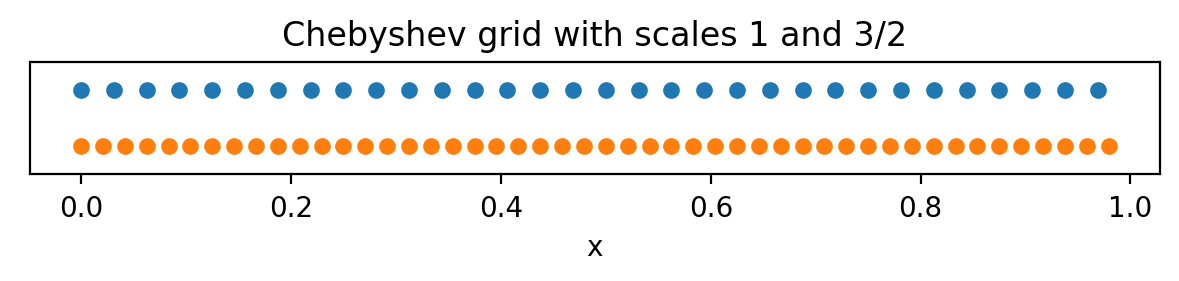

In [9]:
grid_normal = xbasis.global_grid(scale=1).ravel()
grid_dealias = xbasis.global_grid(scale=3/2).ravel()

plt.figure(figsize=(6, 1.5), dpi=100)
plt.plot(grid_normal, 0*grid_normal+1, 'o', markersize=5)
plt.plot(grid_dealias, 0*grid_dealias-1, 'o', markersize=5)
plt.xlabel('x')
plt.title('Chebyshev grid with scales 1 and 3/2')
plt.ylim([-2, 2])
plt.gca().yaxis.set_ticks([]);
plt.tight_layout()

Note that the Chebyshev grids are non-equispaced: the grid points cluster quadratically towards the ends of the interval, which can be very useful for resolving sharp features like boundary layers.

### Distributed grid and element arrays

To help with creating field data, the distributor provides the local portions of the coordinate grids and mode numbers (wavenumbers or polynomial degrees).
The local grids (distributed according to the last layout, or full "grid space") are accessed using the `dist.local_grid` (or `dist.local_grids` for multidimensional bases) method and specifying the basis and scale factors (1 by default):

In [10]:
local_x = dist.local_grid(xbasis)
local_y = dist.local_grid(ybasis)
local_z = dist.local_grid(zbasis)
print('Local x shape:', local_x.shape)
print('Local y shape:', local_y.shape)
print('Local z shape:', local_z.shape)

Local x shape: (32, 1, 1)
Local y shape: (1, 8, 1)
Local z shape: (1, 1, 16)


The local x grid is the full Fourier grid for the x-basis, and will be the same on all processes, since the first axis is local in grid space.
The local y and local z grids will generally differ across processes, since they contain just the local portions of the y and z basis grids, distributed across the specified process mesh (4 blocks in y and 2 blocks in z).

The local modes (distributed according to layout 0, or full "coeff space") are accessed using the `dist.local_modes` method and specifying the basis:

In [11]:
local_kx = dist.local_modes(xbasis)
local_ky = dist.local_modes(ybasis)
local_nz = dist.local_modes(zbasis)
print('Local kx shape:', local_kx.shape)
print('Local ky shape:', local_ky.shape)
print('Local nz shape:', local_nz.shape)

Local kx shape: (8, 1, 1)
Local ky shape: (1, 16, 1)
Local nz shape: (1, 1, 32)


The local kx and local ky elements will now differ across processes, since they contain just the local portions of the x and y wavenumbers, which are distributed in coefficient space.
The local nz elements are the full set of Chebyshev modes, which are always local in coefficient space.

These local arrays can be used to form parallel-safe initial conditions for fields, in grid or coefficient space, as we'll see in the next notebook.